# MSRP Predictor- Keras Regression

#### Dataset Source: https://www.kaggle.com/CooperUnion/cardataset

#### Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import Normalization
from tensorflow.keras.callbacks import EarlyStopping

plt.rcParams["figure.figsize"] = (18,8)

#### Versions of Main Libraries

In [2]:
print("pandas:".ljust(12, ' '), pd.__version__)
print("numpy:".ljust(12, ' '), np.__version__)
print("Seaborn:".ljust(12, ' '), sns.__version__)
print("Tensorflow:".ljust(12, ' '), tf.__version__)
print("Keras:".ljust(12, ' '), keras.__version__)

pandas:      1.4.2
numpy:       1.21.5
Seaborn:     0.11.2
Tensorflow:  2.9.1
Keras:       2.9.0


#### Ingest Data, Drop Unnecessary, & Rename Features

In [3]:
data = pd.read_csv('Car Features and MSRP/data.csv')
data.drop(columns=['Market Category', 'Model'], inplace=True)
data.rename(columns={'Engine Fuel Type' : 'fuel_type', 
                     'Engine HP' : 'hp', 
                     'Engine Cylinders' : 'cylinders', 
                     'Transmission Type' : 'transmission', 
                     'Number of Doors' : 'num_of_doors',
                     'Year' : 'model_year',
                     'highway MPG' : 'higway_fuel_econ',
                     'city mpg' : 'city_fuel_econ',
                     'Driven_Wheels' : 'drivetrain',
                     'MSRP' : 'target'}, inplace=True)

data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11812 entries, 0 to 11913
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Make              11812 non-null  object 
 1   model_year        11812 non-null  int64  
 2   fuel_type         11812 non-null  object 
 3   hp                11812 non-null  float64
 4   cylinders         11812 non-null  float64
 5   transmission      11812 non-null  object 
 6   drivetrain        11812 non-null  object 
 7   num_of_doors      11812 non-null  float64
 8   Vehicle Size      11812 non-null  object 
 9   Vehicle Style     11812 non-null  object 
 10  higway_fuel_econ  11812 non-null  int64  
 11  city_fuel_econ    11812 non-null  int64  
 12  Popularity        11812 non-null  int64  
 13  target            11812 non-null  int64  
dtypes: float64(3), int64(5), object(6)
memory usage: 1.4+ MB


#### More Information About Dataset

In [4]:
data.describe()

,model_year,hp,cylinders,num_of_doors,higway_fuel_econ,city_fuel_econ,Popularity,target
count,11812.000000,11812.000000,11812.000000,11812.000000,11812.000000,11812.000000,11812.000000,1.181200e+04
mean,2010.361581,249.504487,5.649424,3.432526,26.320945,19.328141,1553.679902,4.055994e+04
std,7.594647,109.206947,1.751646,0.882919,7.443589,6.527734,1440.067820,6.028413e+04
min,1990.000000,55.000000,0.000000,2.000000,12.000000,7.000000,2.000000,2.000000e+03
25%,2007.000000,170.000000,4.000000,2.000000,22.000000,16.000000,549.000000,2.099000e+04
50%,2015.000000,227.000000,6.000000,4.000000,26.000000,18.000000,1385.000000,2.997000e+04
75%,2016.000000,300.000000,6.000000,4.000000,30.000000,22.000000,2009.000000,4.220500e+04
max,2017.000000,1001.000000,16.000000,4.000000,354.000000,137.000000,5657.000000,2.065902e+06


#### Numerical vs Categorical Features

In [5]:
print('Numerical Features')

numerical_features = ['hp', 'cylinders', 'num_of_doors', 'higway_fuel_econ', 'city_fuel_econ', 'Popularity']

for x in numerical_features:
    print(x.ljust(18, ' '), len(data[x].unique()))

print('\n-----------------------\n')

print('Categorical Features')

categorical_features = ['model_year', 'Make', 'fuel_type', 'transmission', 'drivetrain', 'Vehicle Size', 'Vehicle Style']

for x in categorical_features:
    print(x.ljust(18, ' '), len(data[x].unique()))


Numerical Features
hp                 355
cylinders          9
num_of_doors       3
higway_fuel_econ   44
city_fuel_econ     50
Popularity         47

-----------------------

Categorical Features
model_year         28
Make               47
fuel_type          9
transmission       5
drivetrain         4
Vehicle Size       3
Vehicle Style      16


#### Remove Outliers

In [6]:
cols_to_check = ['hp', 'cylinders', 'num_of_doors', 'higway_fuel_econ','city_fuel_econ', 'Popularity', 'target']

# Remove outliers using the 'IQR * 1.5' rule
def remove_outliers(df, feature):
    q1, q3 = np.percentile(df[feature], [25,75])
    iqr = q3-q1
    ul = q3 + (iqr * 1.5)
    ll = q1 - (iqr * 1.5)
    neo_data = df[(df[feature].values > ll) & (df[feature].values < ul)]
    return neo_data


for x in cols_to_check:
    data = remove_outliers(data, x)

#### Clean Up Feature Names

In [7]:
data['drivetrain'].replace({'all wheel drive' : 'AWD', 
                                 'four wheel drive' : '4WD', 
                                 'front wheel drive' : 'FWD', 
                                 'rear wheel drive' : 'RWD'}, 
                          inplace=True)

data['transmission'].replace({'AUTOMATED_MANUAL' : 'automated_manual', 
                                   'AUTOMATIC' : 'automatic', 
                                   'DIRECT_DRIVE' : 'direct_drive',
                                   'MANUAL' : 'manual',
                                   'UNKNOWN' : 'unknown_transmission',}, 
                            inplace=True)

data['fuel_type'].replace({'natural gas' : 'natural_gas'}, inplace=True)


#### Visualize Correlation Matrix

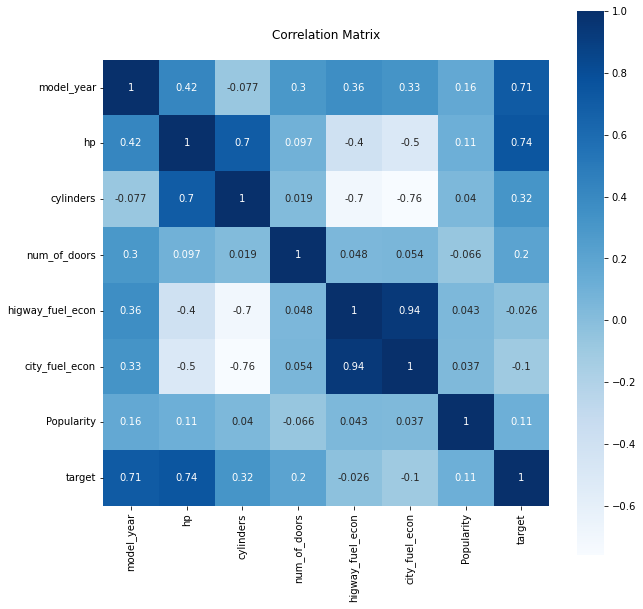

In [8]:
plt.figure(figsize=(10, 10))
plt.title('Correlation Matrix\n')
sns.heatmap(data.corr(), annot=True, cmap="Blues", xticklabels=True, yticklabels=True, square=True)

plt.show()

#### Make Dataset Sparse

In [9]:
# use pandas get_dummies and then merge them to the base table
for x in categorical_features:
    sparse_data = pd.DataFrame(pd.get_dummies(data[x], prefix='', prefix_sep=''))
    data = data.join(sparse_data)
    
# Remove the unnecessary features
data.drop(columns=data.select_dtypes(include='object'), inplace=True)
data.drop(columns=['model_year'], inplace=True)

#### Split Dataset into Training & Testing Datasets

In [10]:
training_data = data.sample(frac=0.75, random_state=42)
testing_data = data.drop(training_data.index)
training_data.head()

,hp,cylinders,num_of_doors,higway_fuel_econ,city_fuel_econ,Popularity,target,1990,1991,1992,...,Convertible,Convertible SUV,Coupe,Crew Cab Pickup,Extended Cab Pickup,Passenger Minivan,Passenger Van,Regular Cab Pickup,Sedan,Wagon
7024,265.0,6.0,2.0,22,17,2009,44540,0,0,0,...,0,1,0,0,0,0,0,0,0,0
7585,116.0,4.0,2.0,20,17,2031,2409,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10400,172.0,6.0,2.0,24,17,1439,21270,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1889,210.0,4.0,2.0,30,24,873,31625,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9098,130.0,4.0,4.0,38,29,2009,17760,0,0,0,...,0,0,0,0,0,0,0,0,1,0


#### Display Descriptive Statistics About Prepared Dataset

In [11]:
training_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
hp,7154.0,228.745457,77.409330,66.0,170.0,210.5,285.0,485.0
cylinders,7154.0,5.366508,1.385704,3.0,4.0,6.0,6.0,8.0
num_of_doors,7154.0,3.488538,0.857004,2.0,3.0,4.0,4.0,4.0
higway_fuel_econ,7154.0,26.429969,5.648215,12.0,23.0,26.0,30.0,42.0
city_fuel_econ,7154.0,19.252306,4.233265,10.0,16.0,19.0,22.0,30.0
...,...,...,...,...,...,...,...,...
Passenger Minivan,7154.0,0.037462,0.189903,0.0,0.0,0.0,0.0,1.0
Passenger Van,7154.0,0.005731,0.075492,0.0,0.0,0.0,0.0,1.0
Regular Cab Pickup,7154.0,0.035085,0.184008,0.0,0.0,0.0,0.0,1.0
Sedan,7154.0,0.264467,0.441080,0.0,0.0,0.0,1.0,1.0


#### Split Both Training & Testing Datasets into Features & Labels

In [12]:
train_features = training_data.copy()
test_features = testing_data.copy()

train_labels = training_data.pop('target')
test_labels = testing_data.pop('target')

#### Display Descriptive Statistics About Prepared Dataset

In [13]:
train_features.describe().transpose()[['mean', 'std']]

,mean,std
hp,228.745457,77.409330
cylinders,5.366508,1.385704
num_of_doors,3.488538,0.857004
higway_fuel_econ,26.429969,5.648215
city_fuel_econ,19.252306,4.233265
...,...,...
Passenger Minivan,0.037462,0.189903
Passenger Van,0.005731,0.075492
Regular Cab Pickup,0.035085,0.184008
Sedan,0.264467,0.441080


#### Basic Statistics on Dataset Labels

In [14]:
print("The mean of the training dataset is {}.".format(round(train_labels.describe()['mean'],2)))

The mean of the training dataset is 28676.11.


#### Normalize Dataset

In [15]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

2022-09-29 21:15:24.278646: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[[2.28745468e+02 5.36650896e+00 3.48853707e+00 2.64299717e+01
  1.92523003e+01 1.18630664e+03 2.86761074e+04 1.20212473e-02
  1.46771027e-02 1.73329581e-02 2.16661952e-02 1.50964549e-02
  1.18814623e-02 1.14621213e-02 1.45373242e-02 1.32792825e-02
  9.92451794e-03 1.17416820e-02 1.56555865e-02 1.74727496e-02
  2.02683825e-02 1.99888311e-02 1.80318691e-02 1.87307708e-02
  3.49454917e-02 3.24294157e-02 3.21498439e-02 2.61392277e-02
  2.53005251e-02 3.32680866e-02 2.85155084e-02 4.40313071e-02
  1.71931773e-01 1.73609227e-01 1.33911043e-01 2.71176919e-02
  5.59127773e-04 2.66983397e-02 2.15264130e-02 2.02683825e-02
  3.21498327e-02 1.12244859e-01 1.99888144e-02 6.40201196e-02
  4.47302265e-03 5.49342968e-02 4.19345772e-04 1.53760077e-03
  3.50852683e-02 2.92144269e-02 3.52250412e-02 2.23651212e-02
  9.64495447e-03 1.69136114e-02 1.59351435e-02 2.23650993e-03
  1.39781914e-04 4.08163331e-02 2.66983528e-02 2.09672786e-02
  5.45149483e-02 1.35588469e-02 8.94603692e-03 1.87307782e-02
  3.7741

#### Display Before & After of Normalization

In [16]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('first example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

first example: [[  265.     6.     2.    22.    17.  2009. 44540.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     1.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      1.     0.     0.     0.     0.     0.     0.     0.     0.     0.
      0.     0.     0.     0.     0.     0.     0.     1.     0.     0.
      0.     1.     0.     0.     0.     1.     0.     0.     0.     0.
      1.     0.     0.     0.     0.     0.     0.     0.     1.     0.
      0.     0.     0.     0.     0.     0.     0.]]

Normalized: [[ 0.47  0.46 -1.74 -0.78 -0.53  0.98  0.99 -0.11 -0.12 -0.13 -0.15 -0.12
  -0.11 -0.11 -0.12 -0.12 -0.1  -0.11 -0.13 -0.13 -0.14 -0.14 -0.14 -0.14
  -0.19 -0.18 -0.18 -0.16 -0.16  5.39 -0.17 -0.21 -

#### Define Metrics

In [17]:
METRICS = [
    tf.keras.metrics.RootMeanSquaredError(name="rmse", dtype=None),
    tf.keras.metrics.MeanAbsoluteError(name="mae", dtype=None)
]

#### Define Function to Build & Compile Model

In [18]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.03)),
        layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l1_l2(l1=0.1, l2=0.03)),
        layers.Dense(1),]
    )
    
    model.compile(loss=tf.keras.losses.MeanAbsoluteError(), 
                  optimizer=tf.keras.optimizers.Adam(0.0002), 
                  metrics = METRICS)
    
    return model

#### Define Function to Display Training vs Validation Loss

In [19]:
def plot_loss(history, left_start, range_upper_limit):
    plt.plot(history.history['mae'], label=['mae'])
    plt.plot(history.history['val_mae'], label=['val_mae'])
    plt.xlabel('Epoch')
    plt.ylim([0, range_upper_limit])
    plt.xlim(left=left_start)
    plt.ylabel('Error (in the MSRP)')
    plt.legend()
    plt.grid(True)
    plt.title('Training vs Validation Loss')
    plt.show()

#### Build & Compile Model, Then Display Input Summary

In [20]:
model = build_and_compile_model(normalizer)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 107)              215       
 n)                                                              
                                                                 
 dense (Dense)               (None, 128)               13824     
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 30,680
Trainable params: 30,465
Non-trainable params: 215
_________________________________________________________________


#### Define Early Stopping Function

In [21]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=9)

#### Fit Model & Assign to Variable

In [22]:
history = model.fit(train_features, 
                        train_labels, 
                        validation_split=0.25, 
                        verbose=2, 
                        epochs=1000,
                        callbacks=early_stopping_callback)

Epoch 1/1000
168/168 - 1s - loss: 28822.9688 - rmse: 32775.4922 - mae: 28630.2715 - val_loss: 28958.7520 - val_rmse: 32933.0312 - val_mae: 28810.8418 - 1s/epoch - 6ms/step
Epoch 2/1000
168/168 - 0s - loss: 28741.2812 - rmse: 32775.0039 - mae: 28629.7148 - val_loss: 28888.9824 - val_rmse: 32932.6523 - val_mae: 28810.4180 - 435ms/epoch - 3ms/step
Epoch 3/1000
168/168 - 0s - loss: 28682.4824 - rmse: 32774.4492 - mae: 28629.0703 - val_loss: 28841.0195 - val_rmse: 32931.8711 - val_mae: 28809.5273 - 377ms/epoch - 2ms/step
Epoch 4/1000
168/168 - 0s - loss: 28645.1387 - rmse: 32773.5703 - mae: 28628.0684 - val_loss: 28814.4707 - val_rmse: 32930.9023 - val_mae: 28808.4258 - 406ms/epoch - 2ms/step
Epoch 5/1000
168/168 - 0s - loss: 28628.6250 - rmse: 32772.4531 - mae: 28626.8066 - val_loss: 28807.0566 - val_rmse: 32929.6055 - val_mae: 28806.9395 - 361ms/epoch - 2ms/step
Epoch 6/1000
168/168 - 0s - loss: 28625.1543 - rmse: 32770.9414 - mae: 28625.0820 - val_loss: 28805.0566 - val_rmse: 32927.8828 

Epoch 49/1000
168/168 - 0s - loss: 2079.2090 - rmse: 1747.1837 - mae: 1111.5542 - val_loss: 2030.5255 - val_rmse: 1671.8212 - val_mae: 1064.3671 - 332ms/epoch - 2ms/step
Epoch 50/1000
168/168 - 0s - loss: 2017.0153 - rmse: 1663.6726 - mae: 1051.3751 - val_loss: 1964.3362 - val_rmse: 1584.9288 - val_mae: 999.2877 - 327ms/epoch - 2ms/step
Epoch 51/1000
168/168 - 0s - loss: 1954.3892 - rmse: 1587.3330 - mae: 990.1257 - val_loss: 1903.6136 - val_rmse: 1497.8462 - val_mae: 939.3330 - 365ms/epoch - 2ms/step
Epoch 52/1000
168/168 - 0s - loss: 1894.7769 - rmse: 1506.4388 - mae: 931.7313 - val_loss: 1850.4915 - val_rmse: 1424.3209 - val_mae: 887.8212 - 355ms/epoch - 2ms/step
Epoch 53/1000
168/168 - 0s - loss: 1835.7198 - rmse: 1427.6174 - mae: 874.0405 - val_loss: 1796.5330 - val_rmse: 1360.1122 - val_mae: 836.6168 - 325ms/epoch - 2ms/step
Epoch 54/1000
168/168 - 0s - loss: 1778.0818 - rmse: 1356.9260 - mae: 817.9254 - val_loss: 1728.2432 - val_rmse: 1263.8259 - val_mae: 768.6429 - 319ms/epoch 

Epoch 99/1000
168/168 - 0s - loss: 945.1434 - rmse: 537.7413 - mae: 80.7941 - val_loss: 938.9042 - val_rmse: 293.3018 - val_mae: 75.7685 - 315ms/epoch - 2ms/step
Epoch 100/1000
168/168 - 0s - loss: 942.8159 - rmse: 536.8322 - mae: 80.6001 - val_loss: 936.4154 - val_rmse: 284.2294 - val_mae: 75.1447 - 313ms/epoch - 2ms/step
Epoch 101/1000
168/168 - 0s - loss: 939.6245 - rmse: 532.8215 - mae: 79.3870 - val_loss: 931.0712 - val_rmse: 287.5093 - val_mae: 71.9138 - 320ms/epoch - 2ms/step
Epoch 102/1000
168/168 - 0s - loss: 936.5497 - rmse: 532.1537 - mae: 78.4766 - val_loss: 924.6375 - val_rmse: 281.0744 - val_mae: 67.5867 - 317ms/epoch - 2ms/step
Epoch 103/1000
168/168 - 0s - loss: 934.1703 - rmse: 533.1309 - mae: 78.1602 - val_loss: 924.9345 - val_rmse: 283.4247 - val_mae: 69.9050 - 310ms/epoch - 2ms/step
Epoch 104/1000
168/168 - 0s - loss: 931.9408 - rmse: 529.2233 - mae: 77.9410 - val_loss: 924.8869 - val_rmse: 282.7709 - val_mae: 71.9650 - 312ms/epoch - 2ms/step
Epoch 105/1000
168/168 

Epoch 150/1000
168/168 - 0s - loss: 836.3082 - rmse: 493.7776 - mae: 63.3703 - val_loss: 825.5073 - val_rmse: 255.6417 - val_mae: 53.4596 - 312ms/epoch - 2ms/step
Epoch 151/1000
168/168 - 0s - loss: 834.4030 - rmse: 493.3678 - mae: 63.0945 - val_loss: 823.3332 - val_rmse: 255.0796 - val_mae: 52.7227 - 312ms/epoch - 2ms/step
Epoch 152/1000
168/168 - 0s - loss: 831.5384 - rmse: 492.3930 - mae: 61.7548 - val_loss: 824.2385 - val_rmse: 253.3755 - val_mae: 55.2741 - 313ms/epoch - 2ms/step
Epoch 153/1000
168/168 - 0s - loss: 830.3533 - rmse: 492.6733 - mae: 62.1146 - val_loss: 822.1034 - val_rmse: 255.3424 - val_mae: 54.6118 - 313ms/epoch - 2ms/step
Epoch 154/1000
168/168 - 0s - loss: 827.9969 - rmse: 492.1677 - mae: 61.2436 - val_loss: 823.2128 - val_rmse: 255.9823 - val_mae: 57.2812 - 310ms/epoch - 2ms/step
Epoch 155/1000
168/168 - 0s - loss: 826.7906 - rmse: 492.0269 - mae: 61.6158 - val_loss: 818.9514 - val_rmse: 255.8777 - val_mae: 54.5634 - 310ms/epoch - 2ms/step
Epoch 156/1000
168/168

#### Plot History of Loss Function (Global View)

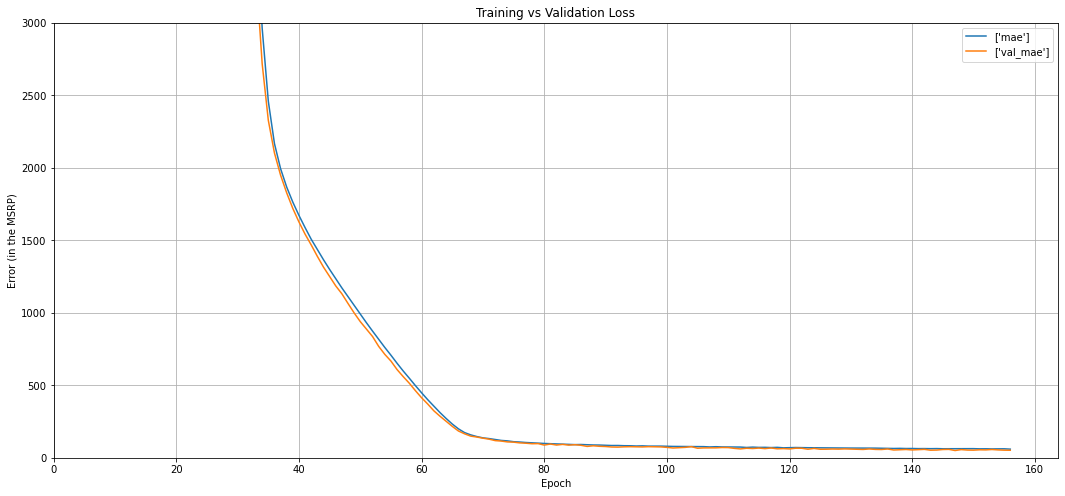

In [23]:
plot_loss(history, 0, 3000)

#### Plot History of Loss Function (Closer Look)

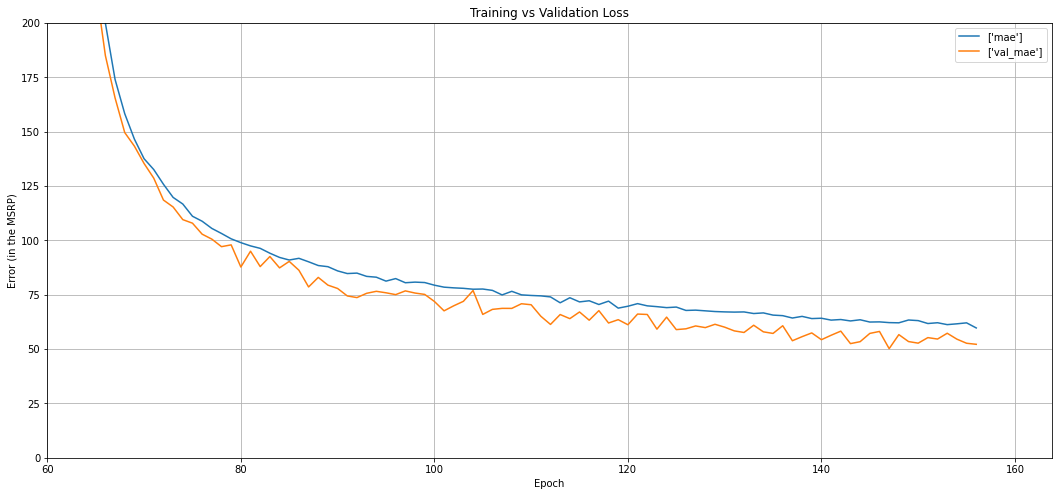

In [24]:
plot_loss(history, 60, 200)

#### Make & Visualize Predictions

75/75 [==============================] - 0s 2ms/step


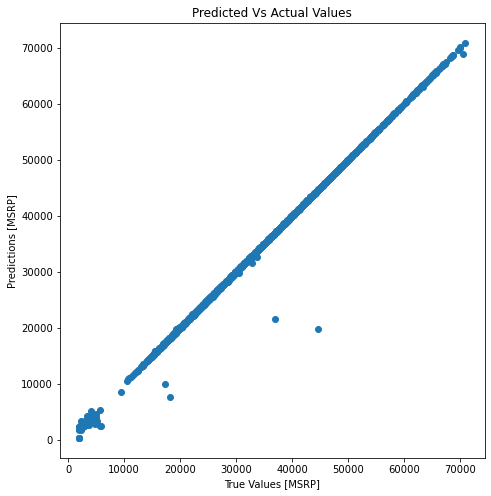

In [25]:
test_predictions = model.predict(test_features).flatten()

plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.title('Predicted Vs Actual Values')
plt.xlabel('True Values [MSRP]')
plt.ylabel('Predictions [MSRP]')
plt.show()

#### Check Error Distribution

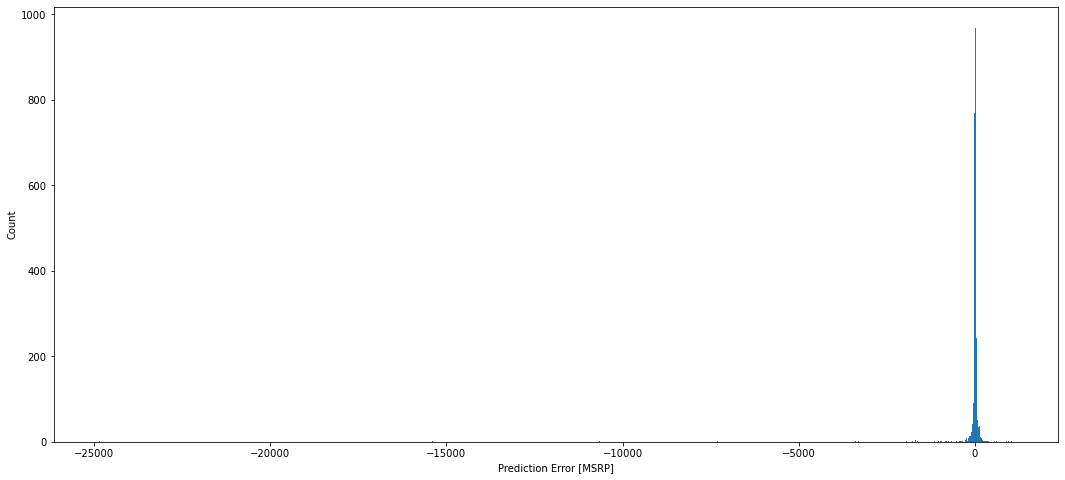

In [26]:
error = test_predictions - test_labels
plt.figure(figsize=(18,8))
plt.hist(error, bins=900)
plt.xlabel('Prediction Error [MSRP]')
_ = plt.ylabel('Count')

#### Save Model

In [27]:
model.save('MSRP Prediction - Keras Regression')

INFO:tensorflow:Assets written to: MSRP Prediction - Keras Regression/assets
